In [2]:
#d=["iwc","dm","attKu","attKa",knn]
import pickle
#read data from knn_impacts2020_Kuo.pklz
#pickle.dump(d,open("knn_impacts2020_Kuo.pklz",'wb'))
d=pickle.load(open("knn_impacts2020_Kuo.pklz",'rb'))
knn=d[4]

In [13]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
with nc.Dataset('/Users/mgrecu/WDomains/IMPACTS_20230217/wrfout_d02_2023-02-17_01:00:00') as f:
    lon=f.variables['XLONG'][0,:,:]
    lat=f.variables['XLAT'][0,:,:]
    qrain=f.variables['QRAIN'][-1,:,:]   
    rainnc=f.variables['RAINNC'][:,:,:]

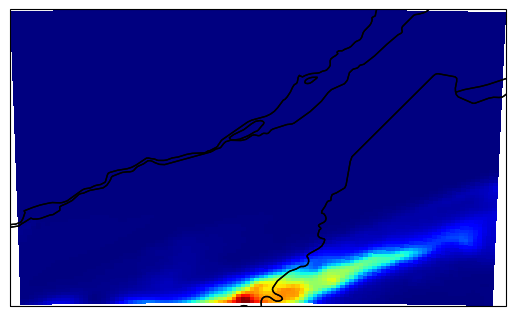

In [14]:
import cartopy.crs as ccrs
import cartopy
ax=plt.axes(projection=ccrs.PlateCarree())
#ax.pcolormesh(lon,lat,rainnc[-4,:,:]-rainnc[-2,:,:],cmap='jet')
ax.pcolormesh(lon,lat,qrain[0,:,:],cmap='jet')
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
